# Exploring beat values

Here we want to break down the data for each record by beat class (N, A, R, J, V, F, etc. - all the classifiable, regular beats).

We want to find some patterns that would allow us to better segment the waveform into PQRSTU components.

In [1]:
import pandas as pd
import numpy as np
import jax.numpy as jnp


# 208 is a good showcase of V type, also contains some F type
# 232 is a good showcase of A type
FILE_NUMBER = 232

RECORD_PATH = f'../data/mit-bih-arrhythmia-database-1.0.0/{FILE_NUMBER}'
CSV_PATH = f'../data/mitbih_database/{FILE_NUMBER}.csv'
ANNOTATIONS_PATH = f'../data/mitbih_database/{FILE_NUMBER}annotations.txt'

ANNOTATIONS_COLUMN_NAMES = ['Time', 'Sample #', 'Type']

DESIRABLE_BEAT_TYPES = ('V', 'L', 'R', 'A', 'F')

In [2]:
times = []
sample_indices = []
arrhytmia_types = []

with open(ANNOTATIONS_PATH, 'r') as fileID:
    data = fileID.readlines()
    beat = list()

    for d in range(1, len(data)): # 0 index is Chart Head
        splitted = data[d].split(' ')
        splitted = filter(None, splitted)
        time = next(splitted) # Time... Clipping
        sample_idx = int(next(splitted)) # Sample ID
        arrhythmia_type = next(splitted) # Type
        if arrhythmia_type in DESIRABLE_BEAT_TYPES:
            times.append(time)
            sample_indices.append(sample_idx)
            arrhytmia_types.append(arrhythmia_type)

df = pd.DataFrame({'Time': times, 'Sample #': sample_indices, 'Type': arrhytmia_types})
df

,Time,Sample #,Type
0,0:01.364,491,R
1,0:02.047,737,A
2,0:02.778,1000,A
3,0:04.608,1659,R
4,0:05.286,1903,A
...,...,...,...
1774,29:59.875,647955,A
1775,30:00.633,648228,A
1776,30:02.347,648845,R
1777,30:03.047,649097,A


In [3]:
df['Type'].value_counts()

A    1382
R     397
Name: Type, dtype: int64

## Exploring original MIT-BIH dataset

### Loading data

In [4]:
import wfdb
import matplotlib.pyplot as plt
from common import *

record = load_record(RECORD_PATH)
record.head(20)

,MLII,V1
0,-0.245,0.210
1,-0.245,0.210
2,-0.245,0.210
3,-0.245,0.210
4,-0.245,0.210
5,-0.245,0.210
6,-0.245,0.210
7,-0.245,0.210
8,-0.240,0.210
9,-0.235,0.215


In [5]:
record_annotation = load_record_annotation(RECORD_PATH)
record_annotation.head(20)

,sample,symbol
0,76,+
1,491,R
2,737,A
3,1000,A
4,1659,R
5,1903,A
6,2156,A
7,2550,~
8,2829,R
9,3066,A


In [6]:
record_annotation['symbol'].value_counts()

A    1382
R     397
~      35
+       1
j       1
Name: symbol, dtype: int64

### Exploring a beat

In [7]:
beats = get_beats_by_symbol(record_annotation, 'A')
beats

,sample,symbol
2,737,A
3,1000,A
5,1903,A
6,2156,A
9,3066,A
...,...,...
1810,647680,A
1811,647955,A
1812,648228,A
1814,649097,A


In [8]:
ecg_signal = np.array(record['MLII'])
window_size = 200

beat_slices = get_beat_slices(beats, ecg_signal, window_size)
beat_slices

array([[-0.225, -0.22 , -0.21 , ..., -0.125, -0.13 , -0.12 ],
       [-0.14 , -0.125, -0.12 , ..., -0.21 , -0.22 , -0.19 ],
       [-0.295, -0.29 , -0.265, ..., -0.22 , -0.26 , -0.285],
       ...,
       [-0.035, -0.035, -0.035, ..., -0.175, -0.175, -0.185],
       [-0.16 , -0.15 , -0.16 , ..., -0.085, -0.09 , -0.1  ],
       [-0.07 , -0.06 , -0.05 , ..., -0.155, -0.13 , -0.13 ]])

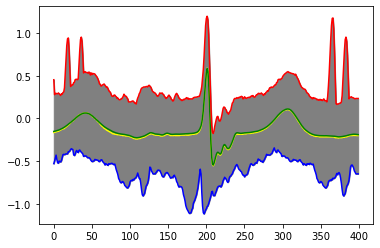

In [9]:
def plot_beat(beat_slices: np.ndarray):
    beat_max = np.max(beat_slices, axis = 0)
    beat_median = np.median(beat_slices, axis = 0)
    beat_mean = np.mean(beat_slices, axis = 0)
    beat_min = np.min(beat_slices, axis = 0)

    plt.plot(beat_min, color='blue')
    plt.plot(beat_median, color='yellow')
    plt.plot(beat_mean, color='green')
    plt.plot(beat_max, color='red')
    plt.fill_between(np.arange(0, beat_min.size), beat_min, beat_max, color = 'gray')

    plt.show()


plot_beat(beat_slices)